# Flight Price Prediction

Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, it will be a different story. We might have often heard travellers saying that flight ticket prices are so unpredictable. Here you will be provided with prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities.

Size of training set: 10683 records

Size of test set: 2671 records

FEATURES:
Airline: The name of the airline.

Date_of_Journey: The date of the journey

Source: The source from which the service begins.

Destination: The destination where the service ends.

Route: The route taken by the flight to reach the destination.

Dep_Time: The time when the journey starts from the source.

Arrival_Time: Time of arrival at the destination.

Duration: Total duration of the flight.

Total_Stops: Total stops between the source and destination.

Additional_Info: Additional information about the flight

Price: The price of the ticket

 

You have to use your skills as a data scientist and build a machine learning model to predict the price of the flight ticket. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import OrdinalEncoder,power_transform,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,KFold
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.linear_model import LinearRegression,Lasso
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import scikitplot as skplt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [14]:
data=pd.read_excel("Data_Train.xlsx")
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [15]:
data['Additional_Info'].unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [16]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [17]:
data.isna().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

There are only two missing values

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


We have only one column that is numeric that is target column

# Preprocessing

1-Doing feature engineering

2-Filling missing values

3-Droping some columns

Dropping Route it is not important because we just want to predict the price so basically we need Source and destination and also Droping additional info because it is not important for fligh fare prediction and also dropping Date of journey because i have converted that into years,month,day and also dropping duration because if we have Dep_time and Arrival_time we dont need it because it just represent the difference between these two only

In [19]:
def preprocess1(df):
    df=df.copy()
    df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])
    df['Year_of_Journey']=df['Date_of_Journey'].dt.year
    df['Month_of_Journey']=df['Date_of_Journey'].dt.month
    df['Day_of_Journey']=df['Date_of_Journey'].dt.day
    df['Total_Stops']=df['Total_Stops'].fillna(df['Total_Stops'].mode()[0])
    df=df.drop(['Route','Date_of_Journey','Duration'],axis=1)
    return df

In [20]:
data=preprocess1(data)

In [21]:
data

,Airline,Source,Destination,Dep_Time,Arrival_Time,Total_Stops,Additional_Info,Price,Year_of_Journey,Month_of_Journey,Day_of_Journey
0,IndiGo,Banglore,New Delhi,22:20,01:10 22 Mar,non-stop,No info,3897,2019,3,24
1,Air India,Kolkata,Banglore,05:50,13:15,2 stops,No info,7662,2019,1,5
2,Jet Airways,Delhi,Cochin,09:25,04:25 10 Jun,2 stops,No info,13882,2019,9,6
3,IndiGo,Kolkata,Banglore,18:05,23:30,1 stop,No info,6218,2019,12,5
4,IndiGo,Banglore,New Delhi,16:50,21:35,1 stop,No info,13302,2019,1,3
...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,19:55,22:25,non-stop,No info,4107,2019,9,4
10679,Air India,Kolkata,Banglore,20:45,23:20,non-stop,No info,4145,2019,4,27
10680,Jet Airways,Banglore,Delhi,08:20,11:20,non-stop,No info,7229,2019,4,27
10681,Vistara,Banglore,New Delhi,11:30,14:10,non-stop,No info,12648,2019,1,3


In [22]:
def preprocess2(df):
    df['Dep_hour']=pd.to_datetime(df['Dep_Time']).dt.hour
    df['Dep_minute']=pd.to_datetime(df['Dep_Time']).dt.minute
    df=df.drop(['Dep_Time'],axis=1)
    df['arrival_hour']=pd.to_datetime(df['Arrival_Time']).dt.hour
    df['arrival_minute']=pd.to_datetime(df['Arrival_Time']).dt.minute
    df=df.drop(['Arrival_Time'],axis=1)
    return df

In [23]:
data=preprocess2(data)

In [24]:
data

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Year_of_Journey,Month_of_Journey,Day_of_Journey,Dep_hour,Dep_minute,arrival_hour,arrival_minute
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,2019,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,2 stops,No info,7662,2019,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,2019,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,2019,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,2019,1,3,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,non-stop,No info,4107,2019,9,4,19,55,22,25
10679,Air India,Kolkata,Banglore,non-stop,No info,4145,2019,4,27,20,45,23,20
10680,Jet Airways,Banglore,Delhi,non-stop,No info,7229,2019,4,27,8,20,11,20
10681,Vistara,Banglore,New Delhi,non-stop,No info,12648,2019,1,3,11,30,14,10


In [25]:
def countplot(x):
    plt.figure(figsize=(12,8))
    sns.countplot(x)
    plt.xticks(rotation=90,fontsize=14)
    plt.yticks(fontsize=14)
    return plt.show()

# Countplot of Airlines

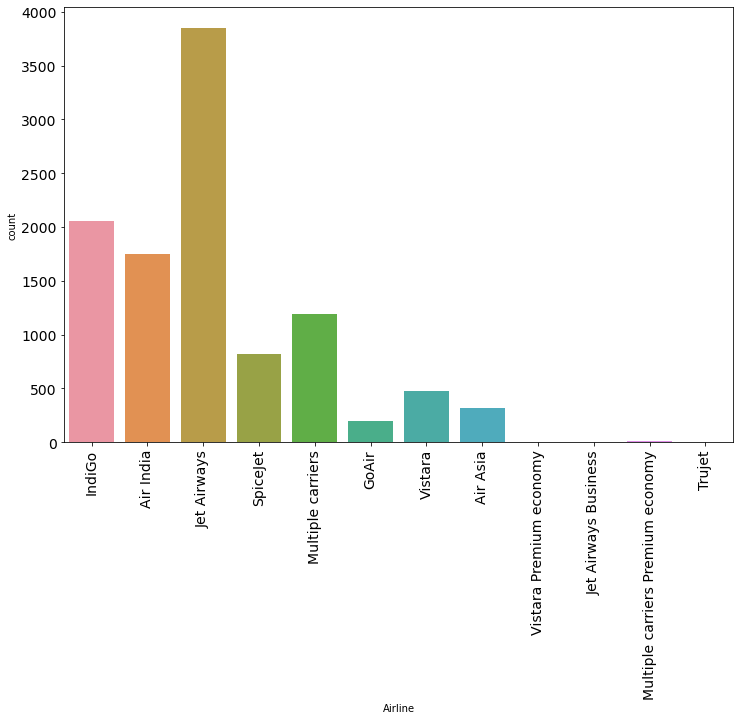

In [26]:
countplot(data['Airline'])

# Obseravtion

1-Mostly people use to travel with Jet Airways

2-After Jet Airways people use to travel with IndiGo

3-ANd GoAir has the least count why i am saying least count because Vistara,Jet Airways,MCPE,Trujet has no count

# Countplot of Source

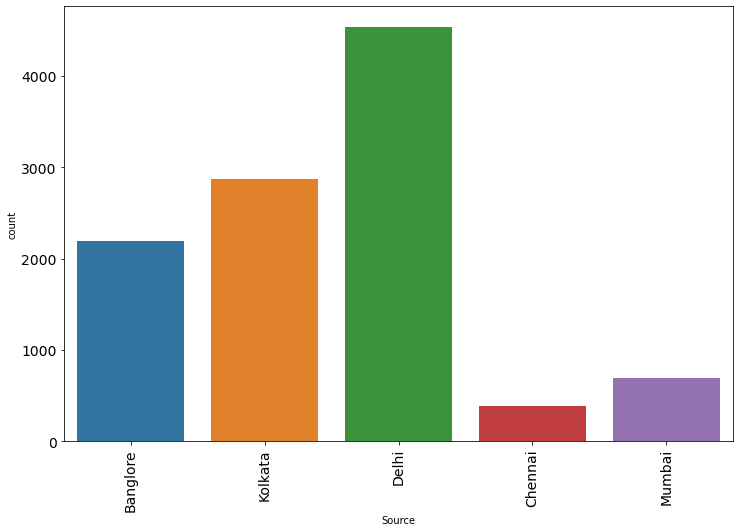

In [27]:
countplot(data['Source'])

# Obseravtion

1-Mostly Source has delhi as high count

2-after delhi kolkata has 2nd high count

3-and at least chennai means very less people source is chennai

# Countplot of Destination

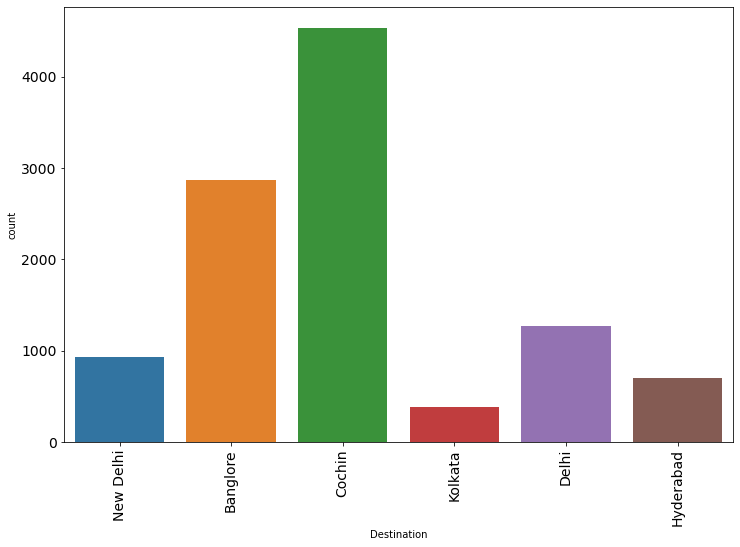

In [28]:
countplot(data['Destination'])

# Obseravtion

1-Mostly people use to go Cochin as per the data what i have

2-after Cochin people use to go to Banglore

3-And very less people use to go to Kolkata

# Countplot of Total_Stops

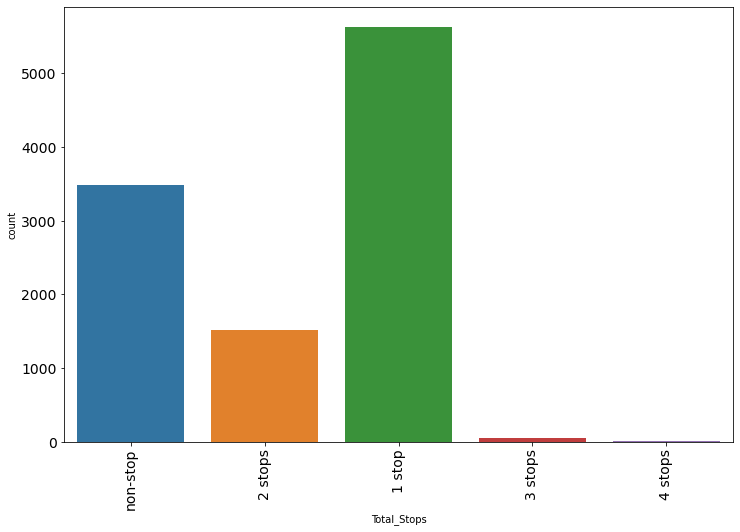

In [29]:
countplot(data['Total_Stops'])

# Obseravtion

1-Mostly people use to take a fligh who has only one stop

2-after one stop people used to take non-stop flights

3-ANd only approx 1500 people use to take 2 stop flights

4-ANd there are very less people who used to take 3 stops or 4 stops flight

# Countplot of Year_of_Journey

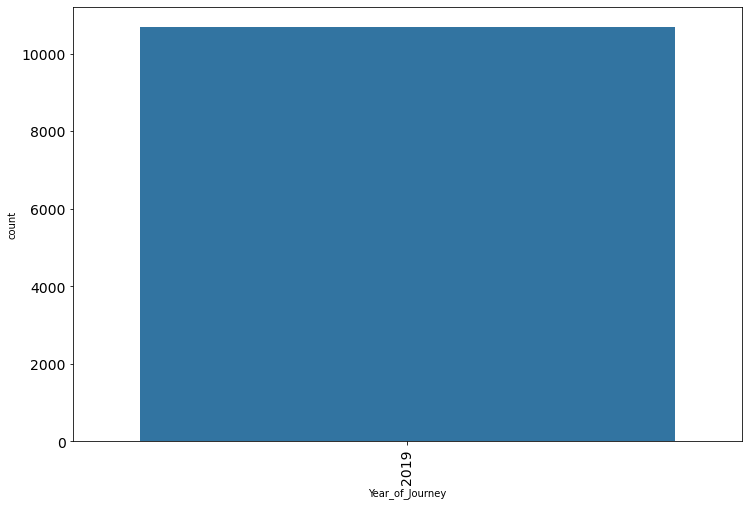

In [30]:
countplot(data['Year_of_Journey'])

# Obseravtion

we have only 2019 data

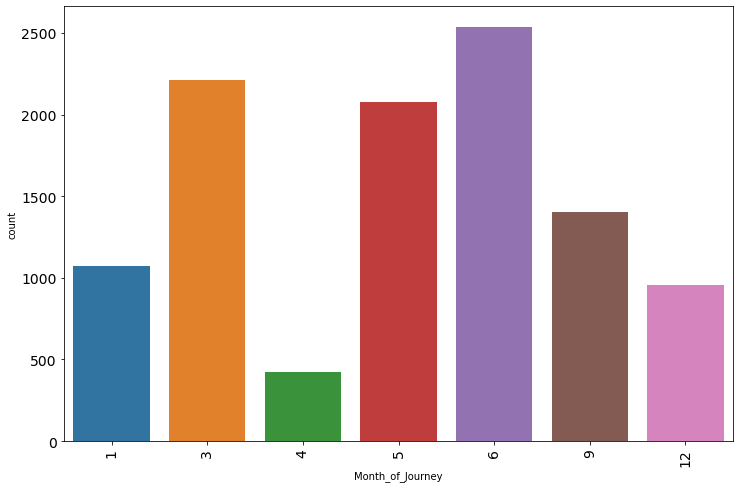

In [31]:
countplot(data['Month_of_Journey'])

# Obseravtion

1-From upper graph i can say mostly people use to take flights in 6th month maybe because children holiday start in 3rd month thats why 3rd month has the 2nd high count so holidays ends in 5th or 6th month so parents with child used to return there home or to school thats why 5th month also has the 3rd high count

2-and 4th has the least count because people use to take less flight in 4th month

3-And in 12th and 9th month people also use to take less flight or used to travel less as compare to 6th,5th and 3rd month

# Countplot of Additional_Info

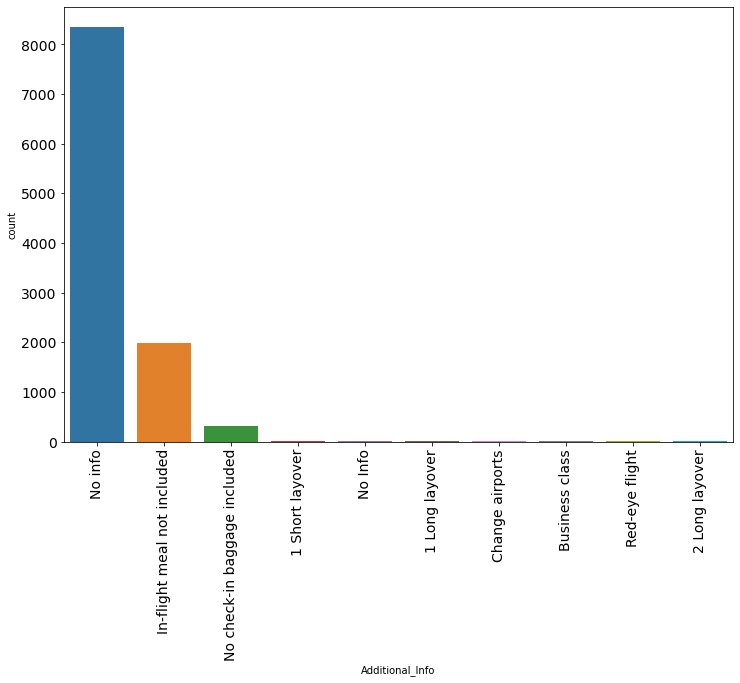

In [32]:
countplot(data['Additional_Info'])

# Obseravtion

1-From upper graph i can say mostly information that is available is no_info

2-and approx 2k people have problem with no meal is included in flight this problem may occur because people have booked a cheap fligh still they want meal which is not possible

3-people have also said that there is no check in baggage included

(array([ 4000.,  5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000.,
        12000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

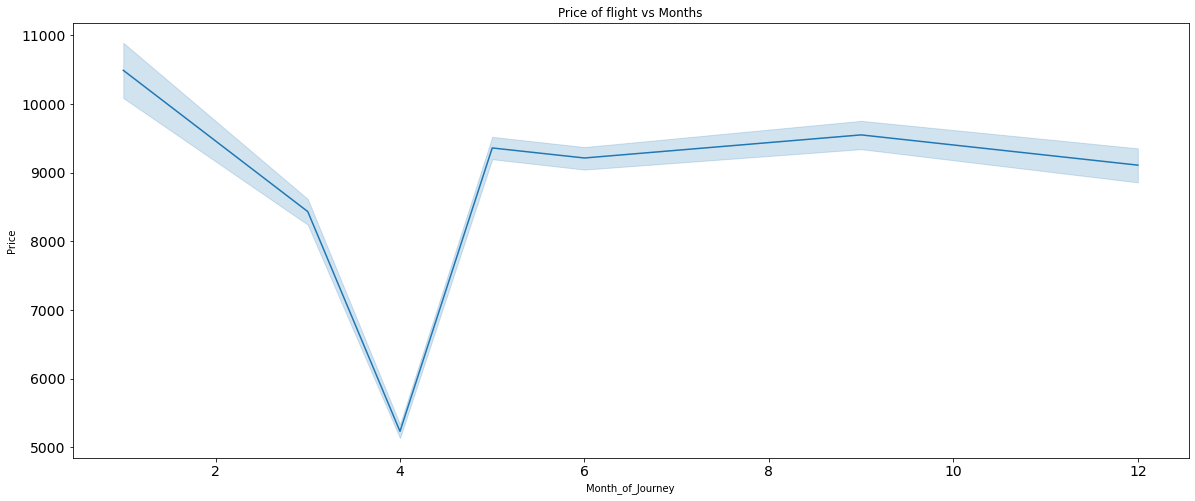

In [33]:
plt.figure(figsize=(20,8))
sns.lineplot(x='Month_of_Journey',y='Price',data=data)
plt.title("Price of flight vs Months")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Obseravtion

from upper graph i can say the highest price are in 1st month

after that price used to get reduce and in 4th month prices are very less

and after 4th month prices used to high

after 5th month price is constant till 12 th month

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000., 70000.,
        80000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

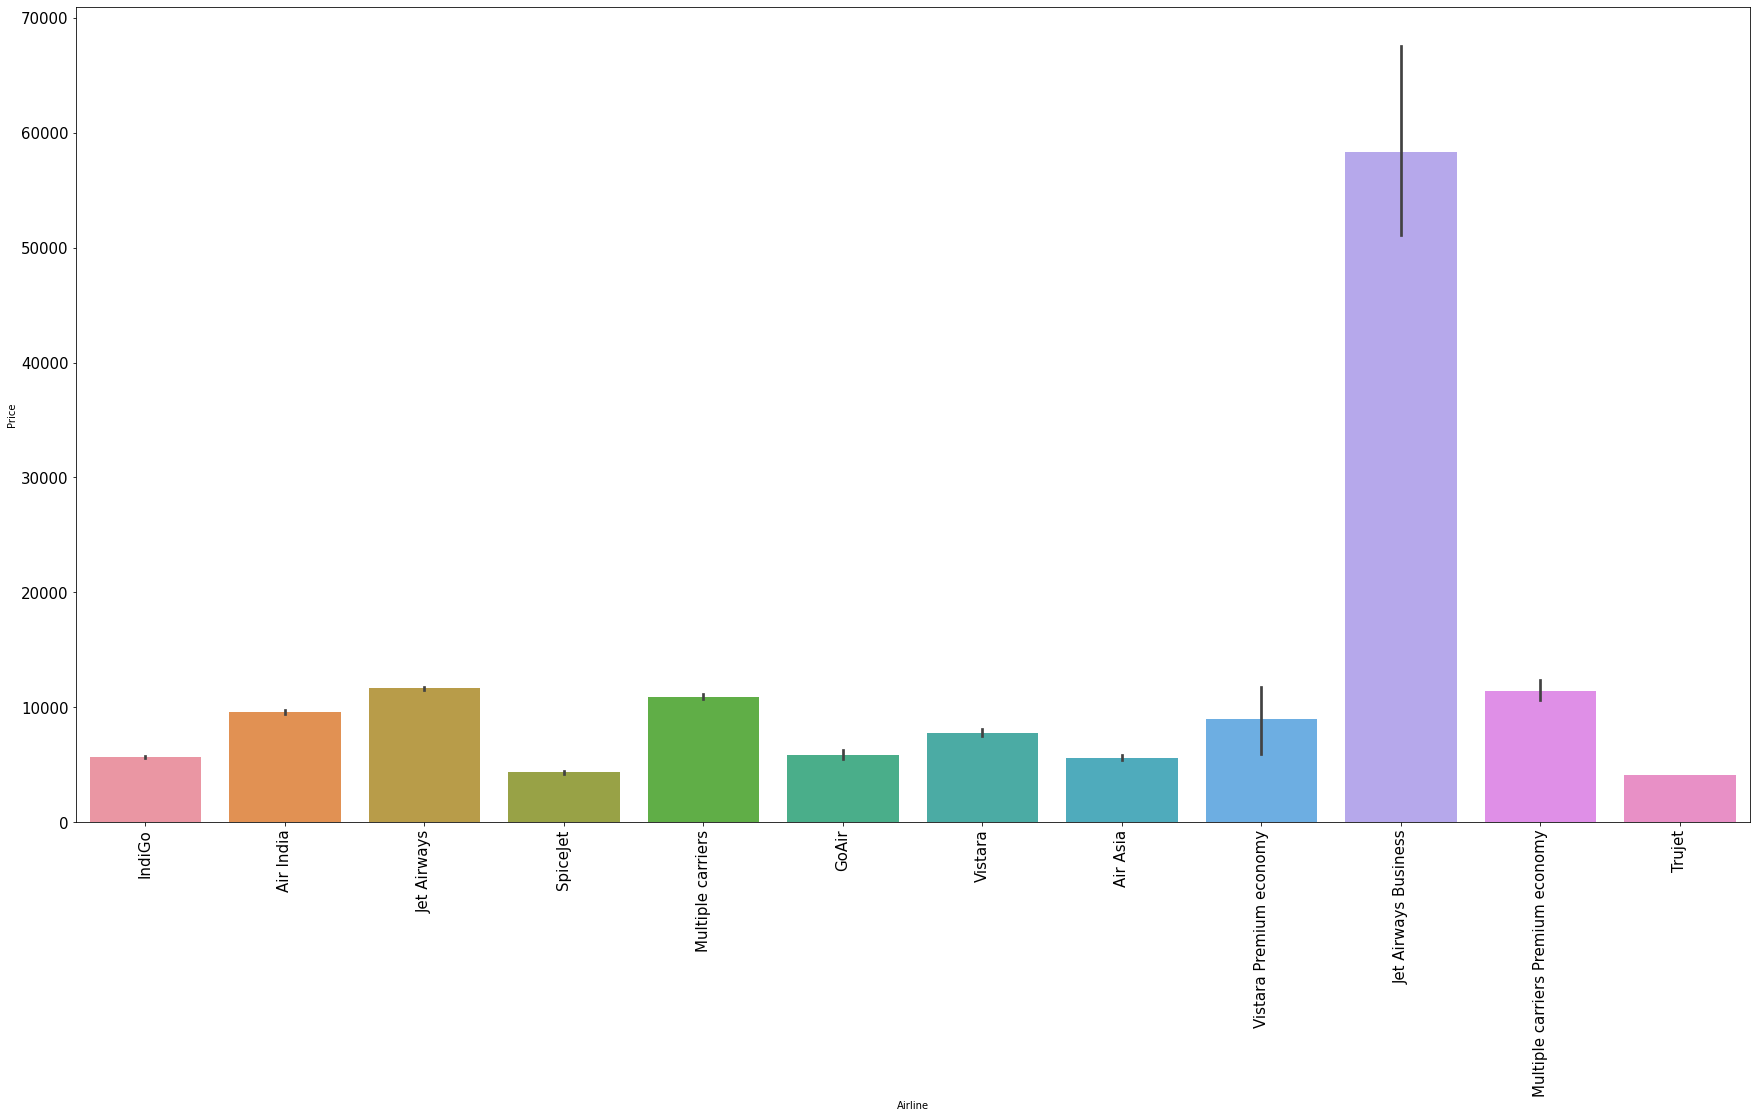

In [34]:
plt.figure(figsize=(30,15))
sns.barplot(x='Airline',y='Price',data=data)
plt.xticks(rotation=90,fontsize=15)
plt.yticks(fontsize=15)

# Obseravtion

1-From upper graph i can say Jet Airways Business has the highest price

2-and spicejet,Indigo,GoAIr,Air Asia is cheap for travel

3-Jet Airways ,Mutiple carriers,Air India have medium price nor high neither low price

In [35]:
data

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Year_of_Journey,Month_of_Journey,Day_of_Journey,Dep_hour,Dep_minute,arrival_hour,arrival_minute
0,IndiGo,Banglore,New Delhi,non-stop,No info,3897,2019,3,24,22,20,1,10
1,Air India,Kolkata,Banglore,2 stops,No info,7662,2019,1,5,5,50,13,15
2,Jet Airways,Delhi,Cochin,2 stops,No info,13882,2019,9,6,9,25,4,25
3,IndiGo,Kolkata,Banglore,1 stop,No info,6218,2019,12,5,18,5,23,30
4,IndiGo,Banglore,New Delhi,1 stop,No info,13302,2019,1,3,16,50,21,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,Air Asia,Kolkata,Banglore,non-stop,No info,4107,2019,9,4,19,55,22,25
10679,Air India,Kolkata,Banglore,non-stop,No info,4145,2019,4,27,20,45,23,20
10680,Jet Airways,Banglore,Delhi,non-stop,No info,7229,2019,4,27,8,20,11,20
10681,Vistara,Banglore,New Delhi,non-stop,No info,12648,2019,1,3,11,30,14,10


# Feature Transformation

In [36]:
#Using ordinal encoder because features values in order

oe=OrdinalEncoder()
def ordinal_encoder(df,col):
    df[col]=oe.fit_transform(df[col])
    return df

In [37]:
data=ordinal_encoder(data,['Airline','Source','Destination','Total_Stops','Additional_Info'])

# Spliting data into dependent and independent variable

In [38]:
def preprocess3(df):
    df=df.copy()
    X=df.drop(['Price'],axis=1)
    y=df['Price']
    return X,y

In [39]:
X,y=preprocess3(data)

In [40]:
#Dropping this column because it has only one value that is 2019
X=X.drop(['Year_of_Journey'],axis=1)

In [41]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

<AxesSubplot:>

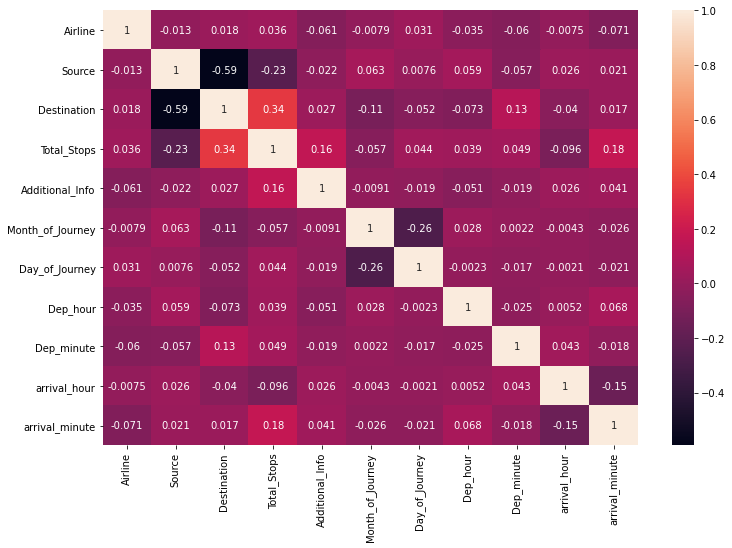

In [42]:
X_corr=X.corr()
plt.figure(figsize=(12,8))
sns.heatmap(X_corr,annot=True)

# Obseravtion

from upper graph i can say most of teh columns are having less correlation because most of every column is categorical and through this correlation we can only find correlation with numerical data

# Checking Outliers

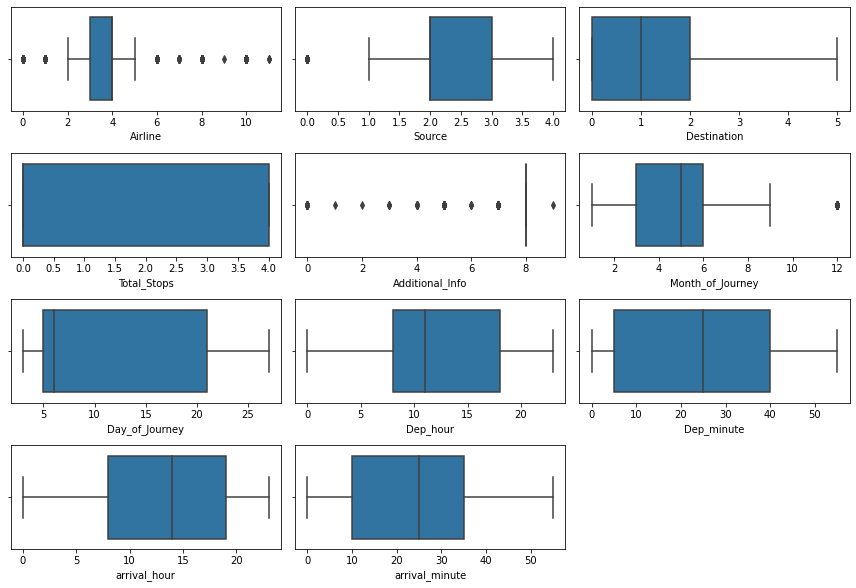

In [43]:
X_val=X.columns.values
plt.figure(figsize=(12,20))
for i in range(len(X_val)):
    plt.subplot(10,3,i+1)
    sns.boxplot(X[X_val[i]])
    plt.tight_layout()

# Observation

there is no outliers because every column is categorical, we dont have any continuous column in X

# Checking Skewness

In [44]:
X.skew()

Airline             0.731095
Source             -0.424054
Destination         1.244169
Total_Stops         0.631681
Additional_Info    -1.779838
Month_of_Journey    0.629540
Day_of_Journey      0.367373
Dep_hour            0.113073
Dep_minute          0.167029
arrival_hour       -0.369988
arrival_minute      0.110945
dtype: float64

# Obseravtion

There is no skewness because every column is categorical we dont remove skewness of categorical column

<b>Note:</b> We are not scaling features because all the features are categorical.    

# Training Multiple models

In [45]:
models={
    "XGB Regressor":XGBRegressor(eval_metric='mlogloss'),
    "ExtraTrees Regressor":ExtraTreesRegressor(),
    "RandomForest Regressor":RandomForestRegressor(),
    "Linear Regression":LinearRegression(),
    "DecisionTree Regressor":DecisionTreeRegressor(),
    "Lasso":Lasso(),
    "LIGHT GBM":LGBMRegressor()
}

************************************** XGB Regressor *******************************************
MEAN SQUARED ERROR 1832344.7281084755


MEAN ABSOLUTE ERROR 766.3224291725576


CVS_SCORE 0.8827131252770221


R2_SCORE 0.909282805714198


RMSE 1353.6412848714667


MODEL PERFORMANCE CURVE


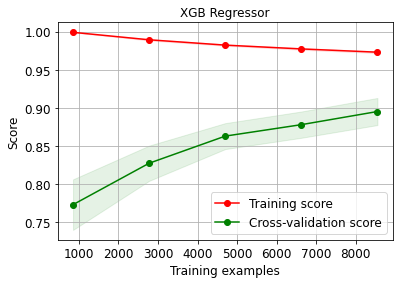

************************************** ExtraTrees Regressor *******************************************
MEAN SQUARED ERROR 2090494.8536767897


MEAN ABSOLUTE ERROR 659.9480696827874


CVS_SCORE 0.8858668233609605


R2_SCORE 0.8965021019869794


RMSE 1445.8543680733512


MODEL PERFORMANCE CURVE


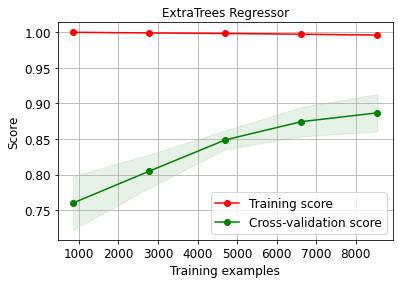

************************************** RandomForest Regressor *******************************************
MEAN SQUARED ERROR 2026168.1360831845


MEAN ABSOLUTE ERROR 674.2570608775519


CVS_SCORE 0.8906717327253488


R2_SCORE 0.8996868407799528


RMSE 1423.4353290835465


MODEL PERFORMANCE CURVE


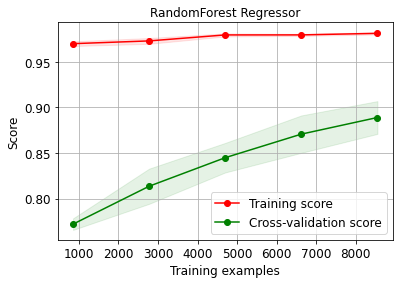

************************************** Linear Regression *******************************************
MEAN SQUARED ERROR 12413993.742844012


MEAN ABSOLUTE ERROR 2609.2599387689156


CVS_SCORE 0.36897694765483446


R2_SCORE 0.3853980285713777


RMSE 3523.349790021424


MODEL PERFORMANCE CURVE


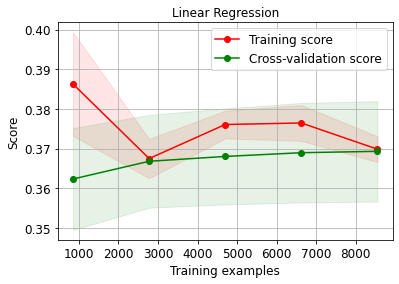

************************************** DecisionTree Regressor *******************************************
MEAN SQUARED ERROR 3960996.0192927714


MEAN ABSOLUTE ERROR 769.1907436297453


CVS_SCORE 0.8115704133060527


R2_SCORE 0.8038958281510669


RMSE 1990.2251177424055


MODEL PERFORMANCE CURVE


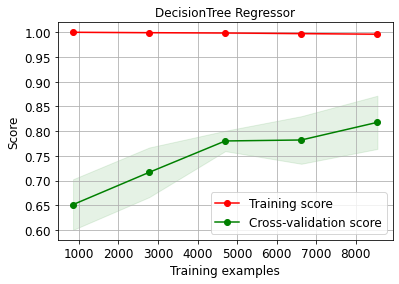

************************************** Lasso *******************************************
MEAN SQUARED ERROR 12413868.25613985


MEAN ABSOLUTE ERROR 2609.2178706471004


CVS_SCORE 0.36863308691228697


R2_SCORE 0.38540424126790096


RMSE 3523.331982107257


MODEL PERFORMANCE CURVE


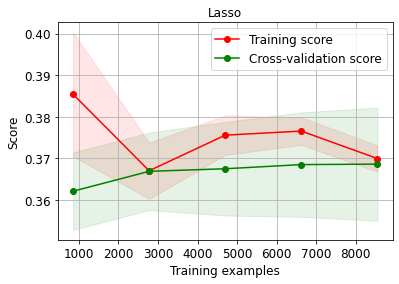

************************************** LIGHT GBM *******************************************
MEAN SQUARED ERROR 2411596.947038205


MEAN ABSOLUTE ERROR 950.5863594904663


CVS_SCORE 0.8667605437346213


R2_SCORE 0.8806047216839207


RMSE 1552.9317264574786


MODEL PERFORMANCE CURVE


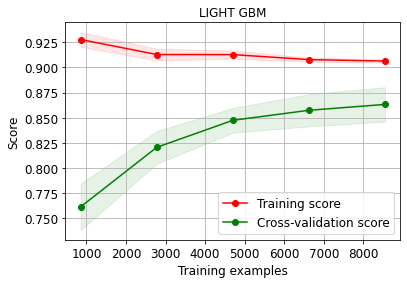

In [79]:
CVS=[]
R2=[]
MSE=[]
MAE=[]
RMSE=[]
NAME=[]
kf=KFold(n_splits=5,shuffle=True)
for name, model in models.items():
    print("**************************************",name,"*******************************************")
    NAME.append(name)
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    mse=mean_squared_error(y_test,y_pred)
    MSE.append(mse)
    print("MEAN SQUARED ERROR",mse)
    mae=mean_absolute_error(y_test,y_pred)
    MAE.append(mae)
    print('\n')
    print("MEAN ABSOLUTE ERROR",mae)
    cvs=cross_val_score(model,X,y,scoring='r2',cv=kf).mean()
    CVS.append(cvs)
    print('\n')
    print("CVS_SCORE",cvs)
    r2=r2_score(y_test,y_pred)
    R2.append(r2)
    print('\n')
    print("R2_SCORE",r2)
    rmse=np.sqrt(mse)
    RMSE.append(rmse)
    print('\n')
    print("RMSE",rmse)
    print('\n')
    print('MODEL PERFORMANCE CURVE')
    skplt.estimators.plot_learning_curve(model,X,y,cv=kf,scoring='r2',title=name,text_fontsize='large')
    plt.show()

In [82]:
models_result=pd.DataFrame({
    "NAME":NAME,
    "Cross_Val_Score":CVS,
    "R2_score":R2,
    "Mean_squared_error":MSE,
    "Mean_Absolute_Error":MAE,
    "RMSE":RMSE
})

In [83]:
models_result

,NAME,Cross_Val_Score,R2_score,Mean_squared_error,Mean_Absolute_Error,RMSE
0,XGB Regressor,0.882713,0.909283,1.832345e+06,766.322429,1353.641285
1,ExtraTrees Regressor,0.885867,0.896502,2.090495e+06,659.948070,1445.854368
2,RandomForest Regressor,0.890672,0.899687,2.026168e+06,674.257061,1423.435329
3,Linear Regression,0.368977,0.385398,1.241399e+07,2609.259939,3523.349790
4,DecisionTree Regressor,0.811570,0.803896,3.960996e+06,769.190744,1990.225118
5,Lasso,0.368633,0.385404,1.241387e+07,2609.217871,3523.331982
6,LIGHT GBM,0.866761,0.880605,2.411597e+06,950.586359,1552.931726


We'll do hyperparameter Tuning of XGBRegressor as it's giving us good CVS and 91% R2 Score

In [74]:
XGB=XGBRegressor()

# Hyperparameter Tuning

In [75]:
params={
    'booster':['gbtree','dart'],
    'importance_type':['gain','split'],
    'max_depth':[6,5,7],
    'n_estimators':[100,200,500]
}

In [76]:
Grid=GridSearchCV(estimator=XGB,param_grid=params,cv=kf,n_jobs=-1,scoring='r2')
Grid.fit(X,y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weig...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=None, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    sub

In [77]:
Grid.best_params_

{'booster': 'dart',
 'importance_type': 'gain',
 'max_depth': 5,
 'n_estimators': 500}

In [78]:
Grid.best_score_

0.8999218859441657

Accuracy increased by 88.27 to 89.99

In [54]:
XGBR=XGBRegressor(booster= 'dart',
 importance_type= 'gain',
 max_depth= 7,
 n_estimators= 200)

In [55]:
XGBR.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

# Final Model Learning Curve

MODEL PERFORMANCE CURVE


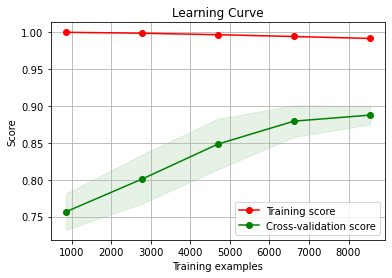

In [56]:
print('MODEL PERFORMANCE CURVE')
skplt.estimators.plot_learning_curve(XGBR,X,y,cv=kf,scoring='r2')
plt.show()

In [57]:
y_pred=XGBR.predict(X_test)

# Final model metrics

In [58]:
print("MSE",mean_squared_error(y_test,y_pred))
print("MAE",mean_absolute_error(y_test,y_pred))
print("RMSE",np.sqrt(mean_squared_error(y_test,y_pred)))
print("R2_Score",r2_score(y_test,y_pred))
print("Model_Score",XGBR.score(X_test,y_test))

MSE 1986103.3859950078
MAE 702.6228279863616
RMSE 1409.2918029971677
R2_Score 0.9016703986018005
Model_Score 0.9016703986018005


In [59]:
import joblib
joblib.dump(Grid,"Flight.obj")

['Flight.obj']

In [60]:
model=joblib.load('Flight.obj')

In [61]:
model.predict(X_test)

array([11246.907 ,  5964.683 , 14827.979 , ...,  5857.024 ,  3349.2302,
       10673.213 ], dtype=float32)

# Loading Test data

In [62]:
data_test=pd.read_excel('Flighttest_set.xlsx')

In [63]:
data_test=preprocess1(data_test)

In [64]:
data_test=preprocess2(data_test)

In [65]:
data_test=data_test.drop(['Year_of_Journey'],axis=1)

In [66]:
data_test

,Airline,Source,Destination,Total_Stops,Additional_Info,Month_of_Journey,Day_of_Journey,Dep_hour,Dep_minute,arrival_hour,arrival_minute
0,Jet Airways,Delhi,Cochin,1 stop,No info,6,6,17,30,4,25
1,IndiGo,Kolkata,Banglore,1 stop,No info,12,5,6,20,10,20
2,Jet Airways,Delhi,Cochin,1 stop,In-flight meal not included,5,21,19,15,19,0
3,Multiple carriers,Delhi,Cochin,1 stop,No info,5,21,8,0,21,0
4,Air Asia,Banglore,Delhi,non-stop,No info,6,24,23,55,2,45
...,...,...,...,...,...,...,...,...,...,...,...
2666,Air India,Kolkata,Banglore,1 stop,No info,6,6,20,30,20,25
2667,IndiGo,Kolkata,Banglore,non-stop,No info,3,27,14,20,16,55
2668,Jet Airways,Delhi,Cochin,1 stop,No info,6,3,21,50,4,25
2669,Air India,Delhi,Cochin,1 stop,No info,6,3,4,0,19,15


In [67]:
data_test=ordinal_encoder(data_test,['Airline','Source','Destination','Total_Stops','Additional_Info'])

# Test data Price prediction

In [68]:
model.predict(data_test)

array([ 9925.199,  3677.557, 10938.26 , ..., 13452.605,  9930.895,
        7776.819], dtype=float32)

# Conclusion

1-Data was having only one continuous value that was our target column.

2-We did EDA to understand the data and wrote the observation.

3-We did all the preprocessing from data cleaning to data transformation and also Feature engineering.

4-All our columns were categorical so there was no need to remove outliers and skewness and no need to apply scaling as well.

3-Finally we build a model that gives us 90% CSV accuracy

4-Finally the model can predict the flight price.